In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def plot_actual_vs_forecast(actual_series, forecast_series, title="Actual vs Forecast", xlabel="Time", ylabel="Value"):
    """
    Plots the actual time series and forecast values on the same plot.

    Parameters:
        actual_series (pd.Series): Time-indexed series of actual values.
        forecast_series (pd.Series): Time-indexed series of forecasted values.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(actual_series, label='Actual', color='black')
    plt.plot(forecast_series, label='Forecast', color='red', linestyle=(0, (5, 5)), linewidth=2)
    plt.axvline(x=forecast_series.index[0], color='blue', linestyle='--', linewidth=1, label='Forecast Start')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def generate_time_series_kfold_datasets(df, n_splits=5, target_col='load'):
    """
    Returns train/test DataFrames for each fold in time series K-fold cross-validation.

    Parameters:
    - df: full time-ordered DataFrame
    - n_splits: number of folds
    - target_col: name of target column (optional, for clarity)

    Returns:
    - List of (train_df, test_df) tuples
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    datasets = []

    for train_idx, test_idx in tscv.split(df):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()
        datasets.append((train_df, test_df))

    return datasets

In [10]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df)
df['load_diff'] = df['load'].diff(periods=1)
df = df.dropna(subset=['load_diff'])
df.drop(columns=['load_diff'], inplace=True)
df['load'], lambda_ = boxcox(df['load'])

In [11]:
# folds = generate_time_series_kfold_datasets(df, n_splits=5)

In [12]:
n = len(df)
split_idx = int(n * 0.8)

train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# AR Model

In [ ]:
selector = ar_select_order(train['load'], maxlag=300, ic='aic')
print("Best lag:", selector.ar_lags)

In [ ]:
model = AutoReg(train['load'], lags=selector.ar_lags)
model = model.fit()

In [ ]:
print("Selected model AIC:", model.aic)

In [ ]:
forecast = model.forecast(steps=len(test))

In [ ]:
plot_actual_vs_forecast(df['load'], forecast)

# MA Model

In [9]:
def find_best_ma_q(series, max_q=200):
    best_aic = float('inf')
    best_q = None
    best_model = None

    for q in max_q:
        model = ARIMA(series, order=(0, 0, q))
        try:
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_q = q
                best_model = result
        except:
            continue  # skip failed models

    return best_q, best_model

In [11]:
best_q, best_model = find_best_ma_q(train['load'], max_q=[12, 24])

D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [13]:
forecast = best_model.forecast(steps=len(test))

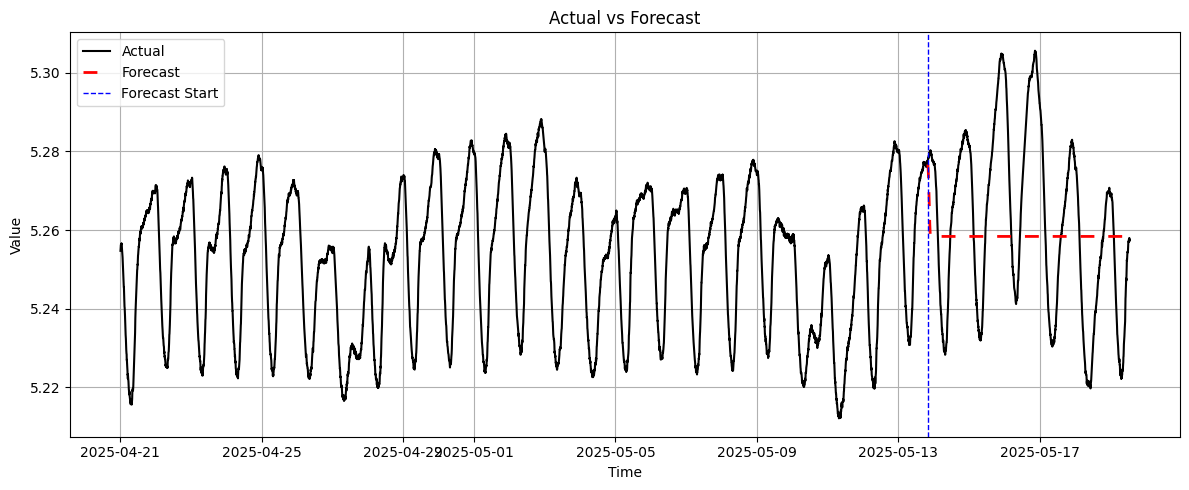

In [14]:
plot_actual_vs_forecast(df['load'], forecast)

# SARIMA Model

In [19]:
model = SARIMAX(
    train['load'],
    order=(1, 1, 1),              # ARIMA(p, d, q)
    seasonal_order=(1, 1, 1, 100) # SARIMA(P, D, Q, s)
)
results = model.fit()

D:\ML\EnergyPrediction\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 

In [17]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

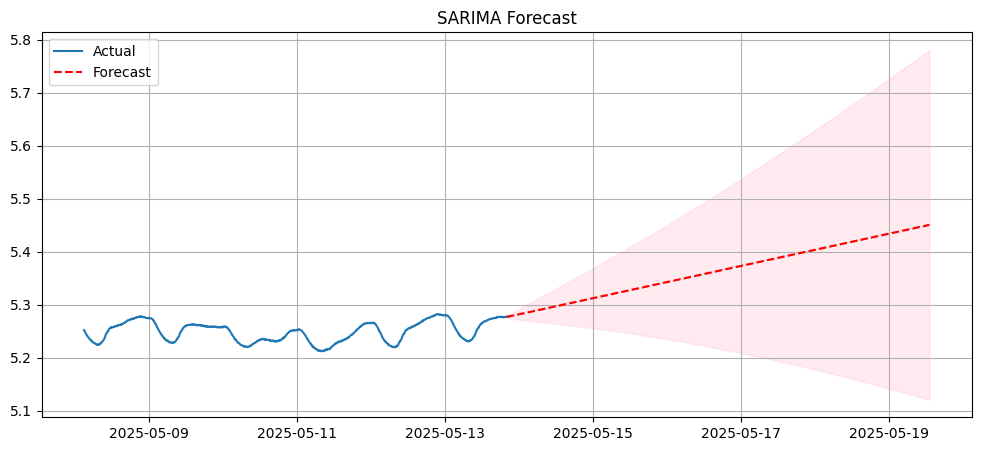

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train[-len(test):], label='Actual')
plt.plot(forecast_mean, label='Forecast', linestyle='--', color='red')
plt.fill_between(
    forecast_mean.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.legend()
plt.title('SARIMA Forecast')
plt.grid()
plt.show()